In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Generate data
n_samples = 20000
y = np.random.uniform(-.5, 2.5, n_samples)
X = y.reshape(-1, 1)
xtrue = np.zeros_like(y)

# Apply conditions to generate xtrue based on y
for i in range(len(xtrue)):
    if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
        xtrue[i] = np.random.normal(1, scale=0.5)
    else:
        xtrue[i] = np.random.normal(-1, scale=0.5)



obs_noise_std = np.random.uniform(0.5, 2.0, len(xtrue))  # Varying noise levels
# Generate x and s (noisy observations)
x = xtrue + np.random.normal(0, obs_noise_std , len(xtrue))
 



In [2]:

# Standardize the input y
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define dataset class that includes observation noise
class DensityRegressionDataset(Dataset):
    def __init__(self, X, y, noise_std):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.noise_std = torch.tensor(noise_std, dtype=torch.float32)  # Noise level for each observation

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.noise_std[idx]  # Return the noise_std as well

# Mixture Density Network (unchanged)
class MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_gaussians):
        super(MDN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.pi = nn.Linear(hidden_dim, n_gaussians)  # Mixing coefficients (weights)
        self.mu = nn.Linear(hidden_dim, n_gaussians)  # Means of Gaussians
        self.log_sigma = nn.Linear(hidden_dim, n_gaussians)  # Log of standard deviations

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        pi = torch.softmax(self.pi(x), dim=1)  # Softmax for mixture weights
        mu = self.mu(x)  # Mean of each Gaussian
        log_sigma = self.log_sigma(x)  # Log standard deviation for stability
        return pi, mu, log_sigma

# Negative log-likelihood loss for MDN with varying observation noise
def mdn_loss_with_varying_noise(pi, mu, log_sigma, y, obs_noise_std):
    sigma = torch.exp(log_sigma)  # Model predicted std (Gaussian std)
    obs_noise_std = obs_noise_std.unsqueeze(1)  # Match the dimensions for broadcasting
    total_sigma = torch.sqrt(sigma**2 + obs_noise_std**2)  # Combine with varying observation noise
    m = torch.distributions.Normal(mu, total_sigma)
    probs = m.log_prob(y.unsqueeze(1))  # Log probability of y under each Gaussian
    log_probs = probs + torch.log(pi + 1e-8)  # Log-prob weighted by pi
    nll = -torch.logsumexp(log_probs, dim=1)  # Logsumexp for numerical stability
    return nll.mean()

# Create dataset and dataloader
dataset = DensityRegressionDataset(X_scaled, x, obs_noise_std)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize model, optimizer, and loss function
n_gaussians = 5  # Number of Gaussians in the mixture
model = MDN(input_dim=1, hidden_dim=64, n_gaussians=n_gaussians)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with updated loss function
n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets, noise_std in dataloader:
        optimizer.zero_grad()
        pi, mu, log_sigma = model(inputs)
        loss = mdn_loss_with_varying_noise(pi, mu, log_sigma, targets, noise_std)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(dataloader):.4f}')

# Generate predictions for plotting
model.eval()
with torch.no_grad():
    y_test = np.linspace(-0.5, 2.5, 1000).reshape(-1, 1)
    y_test_scaled = scaler.transform(y_test)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
    pi, mu, log_sigma = model(y_test_tensor)

    # Compute the posterior mean
    pi_np = pi.numpy()
    mu_np = mu.numpy()
    posterior_mean = np.sum(pi_np * mu_np, axis=1)

 


Epoch 10/200, Loss: 1.7039
Epoch 20/200, Loss: 1.6938
Epoch 30/200, Loss: 1.6899
Epoch 40/200, Loss: 1.6877
Epoch 50/200, Loss: 1.6860
Epoch 60/200, Loss: 1.6878
Epoch 70/200, Loss: 1.6847
Epoch 80/200, Loss: 1.6848
Epoch 90/200, Loss: 1.6851
Epoch 100/200, Loss: 1.6841
Epoch 110/200, Loss: 1.6849
Epoch 120/200, Loss: 1.6840
Epoch 130/200, Loss: 1.6833
Epoch 140/200, Loss: 1.6818
Epoch 150/200, Loss: 1.6845
Epoch 160/200, Loss: 1.6816
Epoch 170/200, Loss: 1.6818
Epoch 180/200, Loss: 1.6826
Epoch 190/200, Loss: 1.6825
Epoch 200/200, Loss: 1.6812


In [3]:
# Set the model to evaluation mode
model.eval()

# Create a DataLoader for the entire training set (no shuffling)
train_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# Get the fitted pi, mu, and log_sigma for the entire dataset
with torch.no_grad():
    for X_batch, _, _ in train_loader:  # Ignore the targets and noise_std during inference
        pi, mu, log_sigma = model(X_batch)  # Predict pi, mu, and log_sigma

# Convert the tensors to numpy arrays
pi_np = pi.numpy()
mu_np = mu.numpy()
log_sigma_np = log_sigma.numpy()

# Concatenate pi, mu, and log_sigma into a single 2D array along axis 1
fitted_params = np.hstack((pi_np, mu_np, log_sigma_np))

# Check the shape of the resulting array and print the first few rows
print(fitted_params.shape)
print(fitted_params[:5])  # First 5 rows as a preview


(20000, 15)
[[ 2.9635354e-04  7.0512660e-13  3.7518647e-12  9.9970359e-01
   1.8827223e-14 -5.0378859e-02 -1.3619138e+00 -2.7488654e+00
  -1.1226048e+00  4.7378917e+00  3.0967468e-01  1.3878725e-01
  -2.8917975e+00 -6.1385065e-01  8.9599991e-01]
 [ 2.1047149e-04  9.9947888e-01  1.0791395e-07  3.1052911e-04
   7.8179049e-08 -1.0570755e+00  9.7673118e-01  1.0074937e+00
  -6.6304439e-01  3.7266281e+00 -2.9678323e+00 -6.3707900e-01
  -2.5112810e+00 -1.7518771e+00  1.7216511e+00]
 [ 3.4351083e-12  4.1905094e-13  5.0111828e-14  4.4267884e-12
   1.0000000e+00 -2.8562148e+00  1.5334185e+00 -9.9194080e-01
  -1.1577581e+00 -1.0445656e+00 -1.7774258e+00 -2.6829710e+00
  -2.0695264e+00 -2.1319785e+00 -6.6341639e-01]
 [ 9.9440187e-01  6.0976613e-10  1.3378061e-10  5.5981157e-03
   2.6705682e-12  1.0303408e+00 -2.5999779e-01 -2.9748827e-01
   6.4826781e-01  4.1125674e+00 -7.4569362e-01 -1.3167580e+00
  -2.3506939e+00 -3.7822640e-01 -3.1960058e-01]
 [ 4.6881475e-03  2.0256793e-07  1.4011974e-07  8.94

In [4]:
import os
import sys
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
from ash import *

est_post = np.zeros(n_samples)
for i in range(n_samples):
  
    est_post[i] = posterior_mean_norm(
        betahat=np.array([x[i]]),
        sebetahat=np.array([obs_noise_std[i]]),
        log_pi=np.log(pi_np[i, :]),
        location= mu_np[i,:],
        scale=   np.sqrt( np.exp(log_sigma_np[i,:])**2  )  # Assuming this is available from earlier in your code
    ).post_mean
 

C:\Users\willi\AppData\Local\Temp\ipykernel_28840\2946903996.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(


In [8]:
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
from ash import *

res_ash = ash( x, np.full(x .shape[0],1))
mse_noisy = np.mean((xtrue - x)**2)
mse_ash = np.mean (( res_ash.post_mean - xtrue)**2)

mse_true = np.mean((est_post - xtrue)**2)
print(f"\nMean Squared Error:")
print(f"MSE (Est Post vs Y Noisy): {mse_noisy:.4f}")
print(f"MSE (Ash Post vs Y True): {mse_ash:.4f}")
print(f"MSE (Est Post vs Y True): {mse_true:.4f}")


Mean Squared Error:
MSE (Est Post vs Y Noisy): 1.7343
MSE (Ash Post vs Y True): 0.9885
MSE (Est Post vs Y True): 0.2170


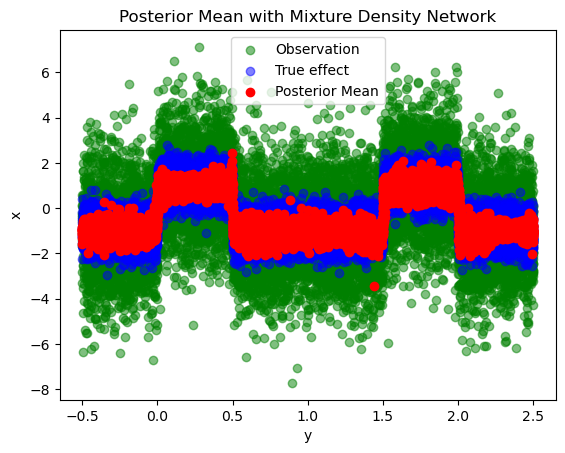

In [10]:
# Plot the posterior mean
plt.scatter(y, x, c='green', label='Observation', alpha=0.5)
plt.scatter(y, xtrue, c='blue', label='True effect', alpha=0.5)
plt.scatter(y, est_post, color='red', label='Posterior Mean')

plt.title('Posterior Mean with Mixture Density Network')
plt.xlabel('y')
plt.ylabel('x')
plt.legend()
plt.show()



Mean Squared Error:
MSE (Est Post vs Y Noisy): 1.7343
MSE (Ash Post vs Y True): 0.9885
MSE (Est Post vs Y True): 0.2170


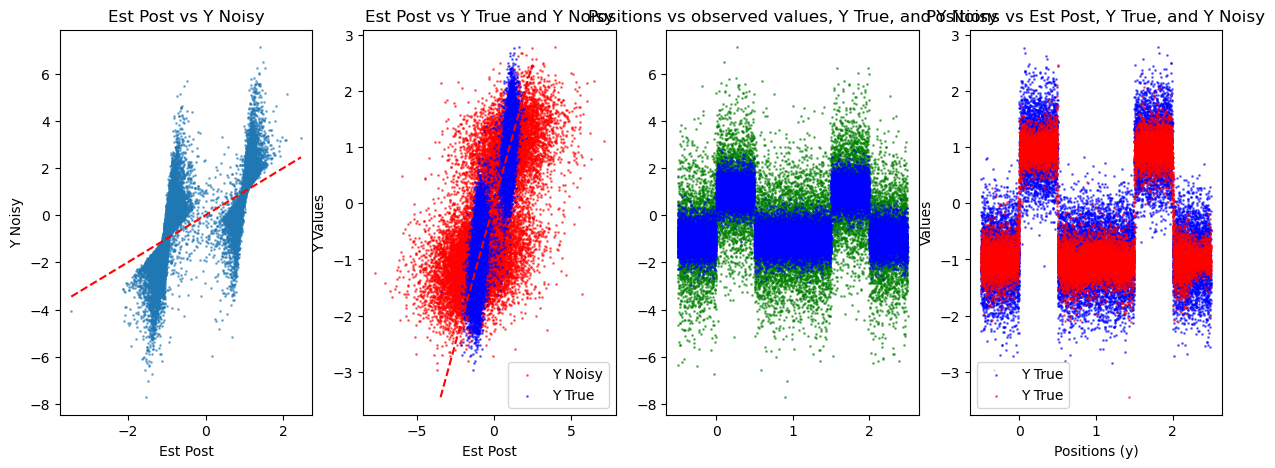

In [7]:
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post, x, alpha=0.5, s=1)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(x, xtrue, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post, xtrue, alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Values')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3)
#plt.scatter(y, y_n_np, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(y, x, alpha=0.5, s=1, label='Y True', color='green')
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True', color='blue')
#plt.scatter(y, x, alpha=0.5, s=1, label='Y True', color='green')
plt.title('Positions vs observed values, Y True, and Y Noisy')
plt.subplot(1,4,4)
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True', color='blue')

plt.scatter(y, est_post, alpha=0.5, s=1, label='Y True', color='red')
plt.title('Positions vs Est Post, Y True, and Y Noisy')
plt.xlabel('Positions (y)')
plt.ylabel('Values')
plt.legend()